In [27]:
import pandas as pd
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, f1_score, make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, StandardScaler

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

from xgboost import XGBClassifier

from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None) 
pd.set_option('display.width', None)  
pd.set_option('display.max_colwidth', None) 

## Preprocessing

In [28]:
cards_data=pd.read_csv("cards_data.csv")
cards_data.head()

,id,client_id,card_brand,card_type,card_number,expires,cvv,has_chip,num_cards_issued,credit_limit,acct_open_date,year_pin_last_changed,card_on_dark_web
0,4524,825,Visa,Debit,4344676511950444,12/2022,623,YES,2,$24295,09/2002,2008,No
1,2731,825,Visa,Debit,4956965974959986,12/2020,393,YES,2,$21968,04/2014,2014,No
2,3701,825,Visa,Debit,4582313478255491,02/2024,719,YES,2,$46414,07/2003,2004,No
3,42,825,Visa,Credit,4879494103069057,08/2024,693,NO,1,$12400,01/2003,2012,No
4,4659,825,Mastercard,Debit (Prepaid),5722874738736011,03/2009,75,YES,1,$28,09/2008,2009,No


In [29]:
evaluation_features=pd.read_csv("evaluation_features.csv")
evaluation_features.head()

,transaction_id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors
0,23042130,2019-06-01 14:41:00,900,3412,$118.61,Swipe Transaction,61195,Panama City,FL,32401.0,5541,NaN
1,22702314,2019-03-21 13:45:00,1741,3025,$-204.00,Chip Transaction,49637,Tucson,AZ,85736.0,3509,NaN
2,22838524,2019-04-19 11:53:00,1081,3892,$-99.00,Chip Transaction,43293,Aurora,CO,80013.0,5499,NaN
3,23477219,2019-09-01 11:46:00,1740,2382,$28.44,Chip Transaction,26032,Mukwonago,WI,53149.0,7210,NaN
4,23066897,2019-06-06 21:24:00,1207,6056,$32.02,Online Transaction,39021,ONLINE,NaN,NaN,4784,NaN


In [30]:
transactions_train=pd.read_csv("transactions_train.csv")
transactions_train.head()

,transaction_id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors
0,19765990,2017-07-07 09:53:00,1581,2519,$12.35,Chip Transaction,20519,Arnold,MO,63010.0,5942,NaN
1,22160255,2018-11-26 17:44:00,1862,4049,$58.29,Chip Transaction,98648,Des Moines,IA,50313.0,5814,NaN
2,17566794,2016-03-26 12:42:00,1967,3367,$11.03,Chip Transaction,46978,Lake Forest,CA,92630.0,5411,NaN
3,17318690,2016-02-01 08:30:00,921,3457,$85.74,Chip Transaction,63701,Rush,NY,14543.0,5411,NaN
4,20994060,2018-03-24 14:42:00,456,2800,$13.43,Chip Transaction,83271,Estero,FL,33928.0,4214,NaN


In [31]:
users_data=pd.read_csv("users_data.csv")
users_data.head()

,id,current_age,retirement_age,birth_year,birth_month,gender,address,latitude,longitude,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards
0,825,53,66,1966,11,Female,462 Rose Lane,34.15,-117.76,$29278,$59696,$127613,787,5
1,1746,53,68,1966,12,Female,3606 Federal Boulevard,40.76,-73.74,$37891,$77254,$191349,701,5
2,1718,81,67,1938,11,Female,766 Third Drive,34.02,-117.89,$22681,$33483,$196,698,5
3,708,63,63,1957,1,Female,3 Madison Street,40.71,-73.99,$163145,$249925,$202328,722,4
4,1164,43,70,1976,9,Male,9620 Valley Stream Drive,37.76,-122.44,$53797,$109687,$183855,675,1


In [32]:
m1_train = pd.merge(
    transactions_train,
    users_data,
    how='left',            
    left_on='client_id',   
    right_on='id' 
)

m2_train = pd.merge(
    m1_train,
    cards_data,
    how='left',             
    left_on='card_id',    
    right_on='id'           
)

X=m2_train

In [33]:
m1_train = pd.merge(
    evaluation_features,
    users_data,
    how='left',            
    left_on='client_id',   
    right_on='id' 
)

m2_train = pd.merge(
    m1_train,
    cards_data,
    how='left',             
    left_on='card_id',    
    right_on='id'           
)

Xt=m2_train

In [34]:
y = pd.read_json("train_fraud_labels.json")
y = y.loc[X['transaction_id'], 'target']

In [35]:
X['date'] = pd.to_datetime(X['date'])
X['year'] = X['date'].dt.year
X['month'] = X['date'].dt.month
X['day'] = X['date'].dt.day
X['hour'] = X['date'].dt.hour
X['minute'] = X['date'].dt.minute
X['second'] = X['date'].dt.second

X['expires'] = pd.to_datetime(X['date'])
X['expires month'] = X['expires'].dt.month
X['expires year'] = X['expires'].dt.year

X['acct_open_date'] = pd.to_datetime(X['date'])
X['acct_open_date year'] = X['acct_open_date'].dt.year
X['acct_open_date month'] = X['acct_open_date'].dt.month
X['acct_open_date day'] = X['acct_open_date'].dt.day
X['acct_open_date hour'] = X['acct_open_date'].dt.hour
X['acct_open_date minute'] = X['acct_open_date'].dt.minute

X['amount'] = X['amount'].str.replace('$', '', regex=False).astype(float)
X['per_capita_income'] = X['per_capita_income'].str.replace('$', '', regex=False).astype(float)
X['total_debt'] = X['total_debt'].str.replace('$', '', regex=False).astype(float)
X['yearly_income'] = X['yearly_income'].str.replace('$', '', regex=False).astype(float)
X['credit_limit'] = X['credit_limit'].str.replace('$', '', regex=False).astype(float)

X = X.drop(columns=['transaction_id', 'address', 'date', 'expires', 'acct_open_date', 'client_id_x',
                                'client_id_y', 'id_x', 'id_y', 'card_id','merchant_city', 'retirement_age',])

X.head()

,amount,use_chip,merchant_id,merchant_state,zip,mcc,errors,current_age,birth_year,birth_month,gender,latitude,longitude,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards,card_brand,card_type,card_number,cvv,has_chip,num_cards_issued,credit_limit,year_pin_last_changed,card_on_dark_web,year,month,day,hour,minute,second,expires month,expires year,acct_open_date year,acct_open_date month,acct_open_date day,acct_open_date hour,acct_open_date minute
0,12.35,Chip Transaction,20519,MO,63010.0,5942,NaN,38,1981,11,Female,38.42,-90.36,21744.0,44334.0,55173.0,684,5,Visa,Debit,4564719638698318,446,YES,1,26596.0,2015,No,2017,7,7,9,53,0,7,2017,2017,7,7,9,53
1,58.29,Chip Transaction,98648,IA,50313.0,5814,NaN,25,1994,4,Female,41.57,-93.61,18568.0,37864.0,57052.0,686,1,Visa,Credit,4495571717001479,778,YES,2,10200.0,2016,No,2018,11,26,17,44,0,11,2018,2018,11,26,17,44
2,11.03,Chip Transaction,46978,CA,92630.0,5411,NaN,55,1964,9,Male,33.64,-117.67,30307.0,61793.0,686.0,767,4,Visa,Debit,4738213924782743,383,YES,2,38120.0,2011,No,2016,3,26,12,42,0,3,2016,2016,3,26,12,42
3,85.74,Chip Transaction,63701,NY,14543.0,5411,NaN,74,1945,5,Male,42.98,-77.67,26072.0,54013.0,3628.0,779,8,Visa,Debit,4319734914723878,720,YES,1,35073.0,2009,No,2016,2,1,8,30,0,2,2016,2016,2,1,8,30
4,13.43,Chip Transaction,83271,FL,33928.0,4214,NaN,54,1965,10,Male,26.63,-81.99,17140.0,34947.0,49024.0,751,3,Visa,Credit,4751933848032848,614,YES,1,5800.0,2009,No,2018,3,24,14,42,0,3,2018,2018,3,24,14,42


In [36]:
Xt['date'] = pd.to_datetime(Xt['date'])
Xt['year'] = Xt['date'].dt.year
Xt['month'] = Xt['date'].dt.month
Xt['day'] = Xt['date'].dt.day
Xt['hour'] = Xt['date'].dt.hour
Xt['minute'] = Xt['date'].dt.minute
Xt['second'] = Xt['date'].dt.second

Xt['expires'] = pd.to_datetime(Xt['date'])
Xt['expires month'] = Xt['expires'].dt.month
Xt['expires year'] = Xt['expires'].dt.year

Xt['acct_open_date'] = pd.to_datetime(Xt['date'])
Xt['acct_open_date year'] = Xt['acct_open_date'].dt.year
Xt['acct_open_date month'] = Xt['acct_open_date'].dt.month
Xt['acct_open_date day'] = Xt['acct_open_date'].dt.day
Xt['acct_open_date hour'] = Xt['acct_open_date'].dt.hour
Xt['acct_open_date minute'] = Xt['acct_open_date'].dt.minute

Xt['amount'] = Xt['amount'].str.replace('$', '', regex=False).astype(float)
Xt['per_capita_income'] = Xt['per_capita_income'].str.replace('$', '', regex=False).astype(float)
Xt['total_debt'] = Xt['total_debt'].str.replace('$', '', regex=False).astype(float)
Xt['yearly_income'] = Xt['yearly_income'].str.replace('$', '', regex=False).astype(float)
Xt['credit_limit'] = Xt['credit_limit'].str.replace('$', '', regex=False).astype(float)

Xt = Xt.drop(columns=['address', 'date', 'expires', 'acct_open_date', 'client_id_x',
                                'client_id_y', 'id_x', 'id_y', 'card_id','merchant_city', 'retirement_age',])

Xt.head()

,transaction_id,amount,use_chip,merchant_id,merchant_state,zip,mcc,errors,current_age,birth_year,birth_month,gender,latitude,longitude,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards,card_brand,card_type,card_number,cvv,has_chip,num_cards_issued,credit_limit,year_pin_last_changed,card_on_dark_web,year,month,day,hour,minute,second,expires month,expires year,acct_open_date year,acct_open_date month,acct_open_date day,acct_open_date hour,acct_open_date minute
0,23042130,118.61,Swipe Transaction,61195,FL,32401.0,5541,NaN,36,1983,7,Male,30.17,-85.67,16133.0,32896.0,69800.0,735,2,Amex,Credit,347103137777594,791,YES,2,4900.0,2009,No,2019,6,1,14,41,0,6,2019,2019,6,1,14,41
1,22702314,-204.00,Chip Transaction,49637,AZ,85736.0,3509,NaN,92,1927,10,Male,32.21,-110.88,17460.0,24960.0,889.0,707,9,Visa,Debit (Prepaid),4148892255805747,546,YES,1,56.0,2010,No,2019,3,21,13,45,0,3,2019,2019,3,21,13,45
2,22838524,-99.00,Chip Transaction,43293,CO,80013.0,5499,NaN,31,1988,9,Female,39.69,-104.81,24849.0,50666.0,102318.0,617,3,Mastercard,Debit,5307705411215347,574,YES,1,27377.0,2016,No,2019,4,19,11,53,0,4,2019,2019,4,19,11,53
3,23477219,28.44,Chip Transaction,26032,WI,53149.0,7210,NaN,36,1983,12,Male,42.86,-88.33,28215.0,57532.0,61268.0,735,4,Mastercard,Debit,5039643704248503,50,YES,1,20612.0,2019,No,2019,9,1,11,46,0,9,2019,2019,9,1,11,46
4,23066897,32.02,Online Transaction,39021,NaN,NaN,4784,NaN,41,1978,10,Male,41.47,-81.67,27646.0,56368.0,71544.0,664,3,Visa,Debit,4093103228262000,507,YES,1,17010.0,2011,No,2019,6,6,21,24,0,6,2019,2019,6,6,21,24


## ML estimators

In [37]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Colonnes
categorical_cols = X_train.select_dtypes(include='object').columns
numeric_cols = X_train.select_dtypes(include='number').columns

# Préprocessing
preprocessor = ColumnTransformer([
    ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categorical_cols),
    ('num', StandardScaler(), numeric_cols)
])

# Pipeline avec placeholder pour le classifieur
model = Pipeline([
    ('preprocess', preprocessor),
    ('classifier', RandomForestClassifier())  # placeholder
])

# Grille avec plusieurs modèles et paramètres spécifiques
param_grid = [
    {
        'classifier': [RandomForestClassifier(random_state=42)],
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [None, 20],
        'classifier__min_samples_split': [2, 5],
        'classifier__min_samples_leaf': [1, 2]
    },
    {
        'classifier': [AdaBoostClassifier(random_state=42)],
        'classifier__n_estimators': [50, 100],
        'classifier__learning_rate': [0.5, 1.0]
    },
    {
        'classifier': [KNeighborsClassifier()],
        'classifier__n_neighbors': [5, 10],
        'classifier__weights': ['uniform', 'distance']
    },
    {
        'classifier': [XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)],
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [3, 6],
        'classifier__learning_rate': [0.1, 0.3]
    }
]

# Scorer
f1_scorer = make_scorer(f1_score, pos_label='Yes')

# GridSearchCV
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring=f1_scorer,
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

print("Meilleur modèle :", best_model)
print("Meilleurs paramètres :", grid_search.best_params_)


In [38]:
# Extract F1 scores for each estimator from GridSearchCV results
results = grid_search.cv_results_
estimators = param_grid
f1_scores = []

for i, estimator in enumerate(estimators):
    mean_f1 = results['mean_test_score'][i]
    f1_scores.append((str(estimator['classifier'][0]), mean_f1))

# Display the F1 scores for each estimator
for estimator_name, f1_score_value in f1_scores:
    print(f"Estimator: {estimator_name}, F1 Score: {f1_score_value}")

Estimator: RandomForestClassifier(random_state=42), F1 Score: 0.4152591857857512
Estimator: AdaBoostClassifier(random_state=42), F1 Score: 0.3745915347622163
Estimator: KNeighborsClassifier(), F1 Score: 0.3839351888012358
Estimator: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tre

In [39]:
# {'classifier': RandomForestClassifier(random_state=42), 'classifier__max_depth': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}
print(grid_search.best_params_)

{'classifier': RandomForestClassifier(random_state=42), 'classifier__max_depth': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}


In [40]:
categorical_cols = X_train.select_dtypes(include='object').columns
numeric_cols = X_train.select_dtypes(include='number').columns
preprocessor = ColumnTransformer([
    ('cat', 
        Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
        ]), 
        categorical_cols),
    ('num', 
        Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), 
        numeric_cols)
])

model = ImbPipeline([
    ('preprocess', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100))
])

model.fit(X_train, y_train)
y_pred = model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred, pos_label='Yes')

print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")

Accuracy: 0.999
F1 Score: 0.5227272727272727


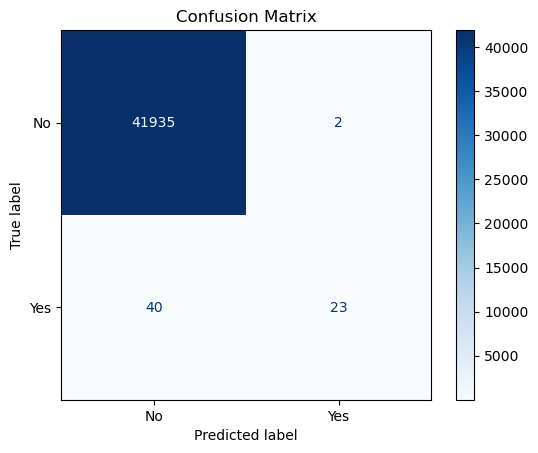

In [41]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_val, y_pred, labels=['No', 'Yes'])
ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['No', 'Yes']).plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

In [43]:
id = Xt['transaction_id']
Xt = Xt.drop(columns=['transaction_id'])

In [44]:
X_test = Xt
y_pred = model.predict(X_test)
submission = pd.DataFrame({
    'id': id,
    'target': y_pred
})
submission.to_csv('submission_cqlj_consulting.csv', index=False)